# Demand

PyPSA-GB uses the ESPENI (Elexon Sum Plus Embedded Net Imports) dataset from https://zenodo.org/record/3884859. This is a cleaned dataset using both National Grid and Elexon data to develop historical half hourly electricity profiles which represent the total system demand of the GB. Essentially, system view data (from Elexon) is added to embedded generation, i.e., distribution-connected solar and wind, and interconnector imports (both from National Grid). Therefore, generation at distribution level and interconnectors should be added separately. This is available from 2008-11-06 up to 2021-06-06 (as of 2021-06-17). See https://doi.org/10.1016/j.esr.2021.100743 for the paper Calculating Great Britain's half-hourly electrical demand from publicly available data which describes the methodology for deriving this dataset.

Load distribution across buses from the Future Energy Scenario Regional Breakdown worksheet. Historical years use 2020 distribution for all timeperiods.

Future demand profiles are generated by scaling historical demand profiles according to FES data specific to different scenarios.

In [6]:
import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv())
src_path = os.environ.get('PROJECT_SRC')
os.chdir(src_path)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature

import imageio

from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point

from statistics import mean

import loads

## Historical data - ESPENI

Historical load data is included in the form of the ESPENI dataset. This provides the load profile for the whole GB power system. National Grid's FES2021 data includes a regional breakdown of projected demand by grid supply point which can be mapped to the nearest bus. The 2020 data for these regional breakdown is used to distribute the load across the buses for the historical years 2010-2020. The load distribution is plotted below for a three day period in December.

29


Text(0.5, 1.0, 'Reduced Network GB with Load Distribution for 1-3 December')

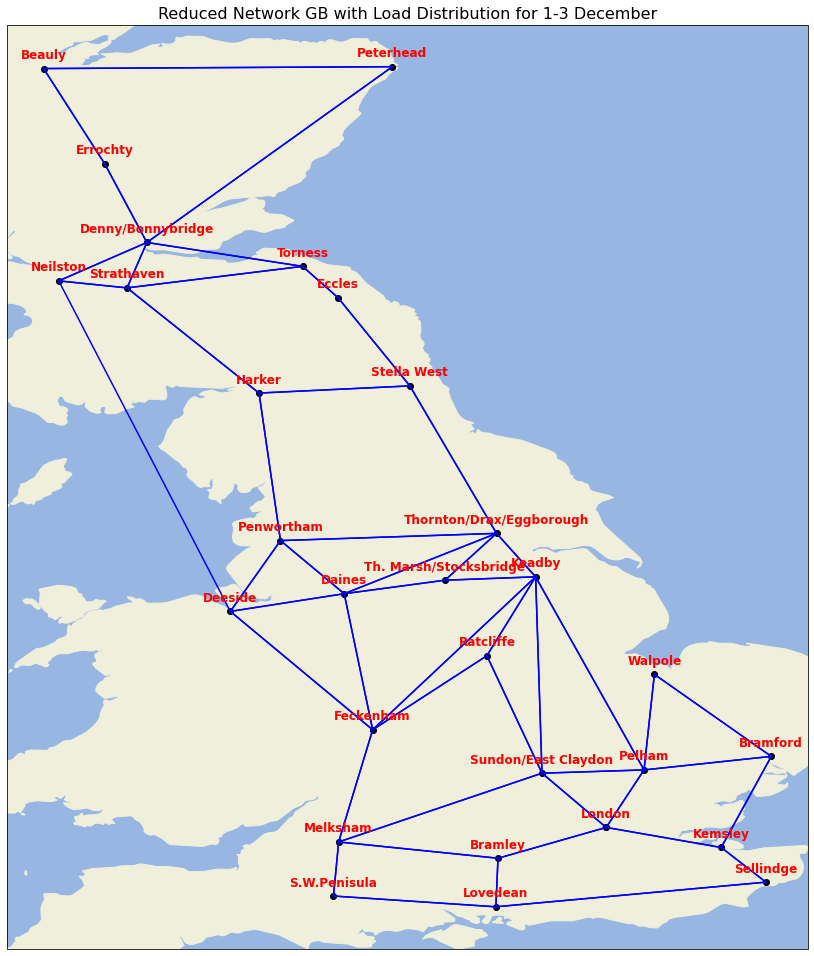

In [8]:
df_network = pd.read_csv('../data/network/buses.csv')[:29]
lon = df_network['x'].values
lat = df_network['y'].values

coordinates = np.zeros(shape=(len(lon), 2))
for i in range(len(lon)):
    coordinates[i][0] = lon[i]
    coordinates[i][1] = lat[i]

df_load = pd.read_csv('LOPF_data/loads-p_set.csv', index_col=0).iloc[:, :29]
sizes = df_load.sum(axis=0).values
marker_scaler = 0.00007

df_lines = pd.read_csv('../data/network/lines.csv', index_col=0)
df_buses = pd.read_csv('../data/network/buses.csv', index_col=0)

line_coordinates = []
for i in range(len(df_lines['bus0'].values)):

    bus0 = df_lines['bus0'].iloc[i]
    bus1 = df_lines['bus1'].iloc[i]
    bus0_coord = [df_buses['x'][bus0], df_buses['y'][bus0]]
    bus1_coord = [df_buses['x'][bus1], df_buses['y'][bus1]]
    line_coordinates.append([bus0_coord, bus1_coord])

fig = plt.figure()
fig.set_size_inches(15, 17)
ax = fig.add_subplot(1, 1, 1,
                     projection=ccrs.PlateCarree())

ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.LAND)

for i in range(len(df_lines['bus0'].values)):
    ax.plot([line_coordinates[i][0][0], line_coordinates[i][1][0]],
            [line_coordinates[i][0][1], line_coordinates[i][1][1]],
            c='blue')
print(len(sizes * marker_scaler))
ax.scatter(lon, lat, s=sizes * marker_scaler, edgecolors='black')
ax.scatter(lon, lat, c='black', edgecolors='black')
for i, txt in enumerate(df_buses[:29].index):
    ax.annotate(txt, (lon[i], lat[i]),
                xytext=(0, 10),
                textcoords="offset points",
                ha='center',
                fontweight='extra bold',
                color='red',
                fontsize='large')

ax.set_title('Reduced Network GB with Load Distribution for 1-3 December', fontsize=16)

The ESPENI dataset is plotted for the entire dataset, over 2020, and over 01/01/2020.

In [9]:
df_loads = loads.read_historical_demand_data()
df_loads.rename(columns={'POWER_ESPENI_MW': 'load'}, inplace=True)
# add columns with year, month, and weekday name
df_loads['Year'] = df_loads.index.year
df_loads['Month'] = df_loads.index.month

Text(0, 0.5, 'Load [MW]')

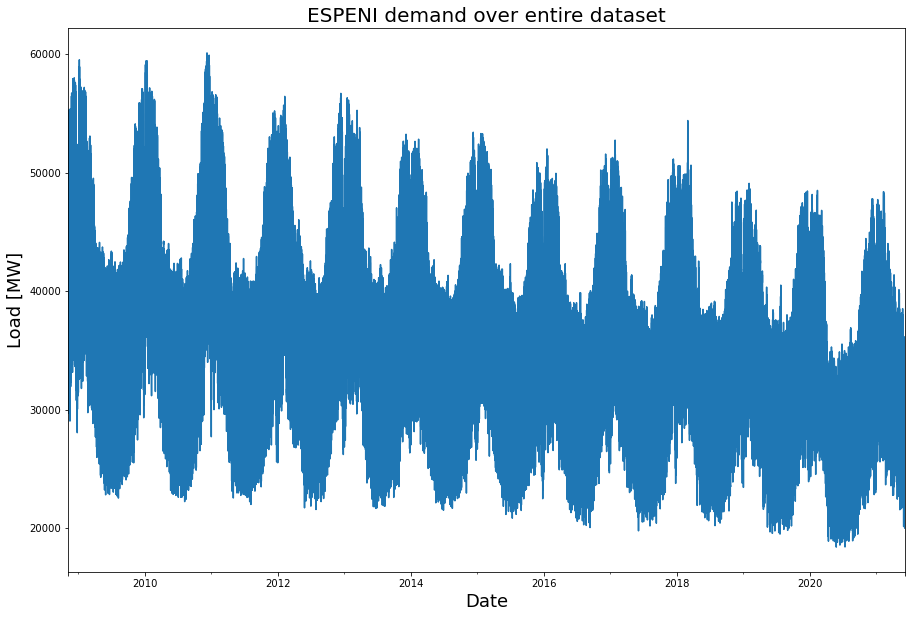

In [10]:
# Plot demand data
df_loads['load'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over entire dataset', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Load [MW]')

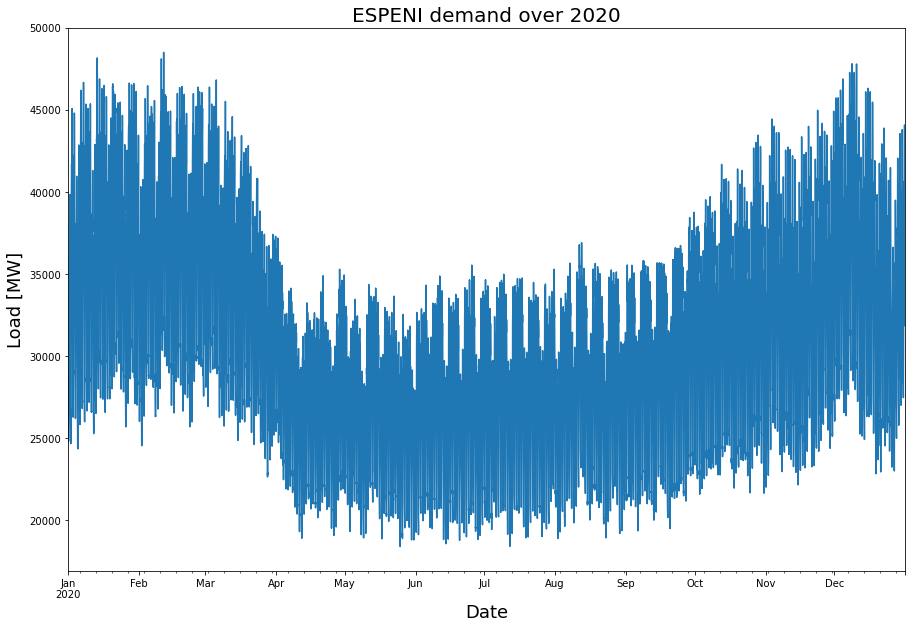

In [11]:
# Plot demand data
df_loads.loc['2020', 'load'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 2020', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Load [MW]')

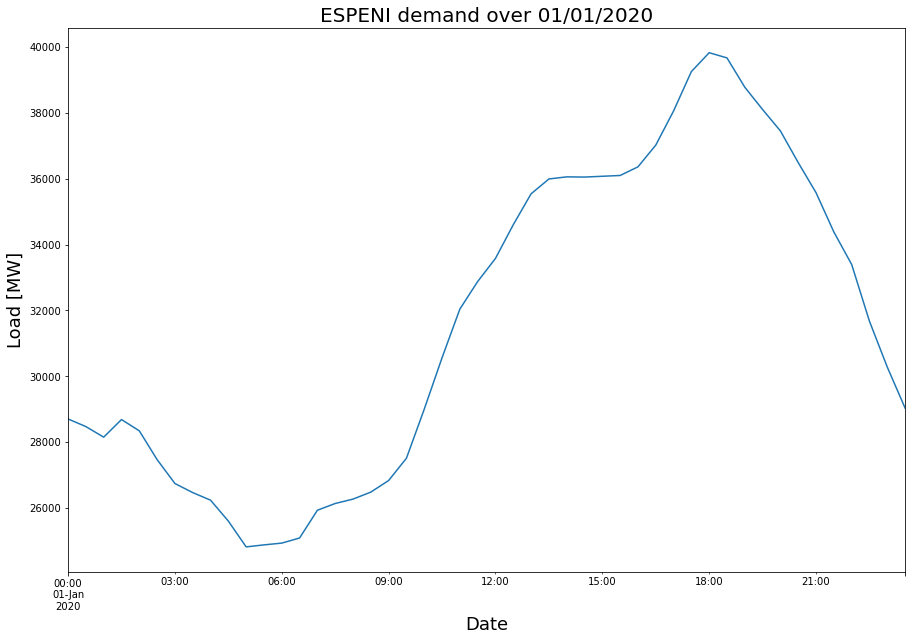

In [12]:
# Plot demand data
df_loads.loc['2020', 'load']['2020-01-01 00:00:00': '2020-01-01 23:30:00'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 01/01/2020', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

Text(0, 0.5, 'Supply [kWh]')

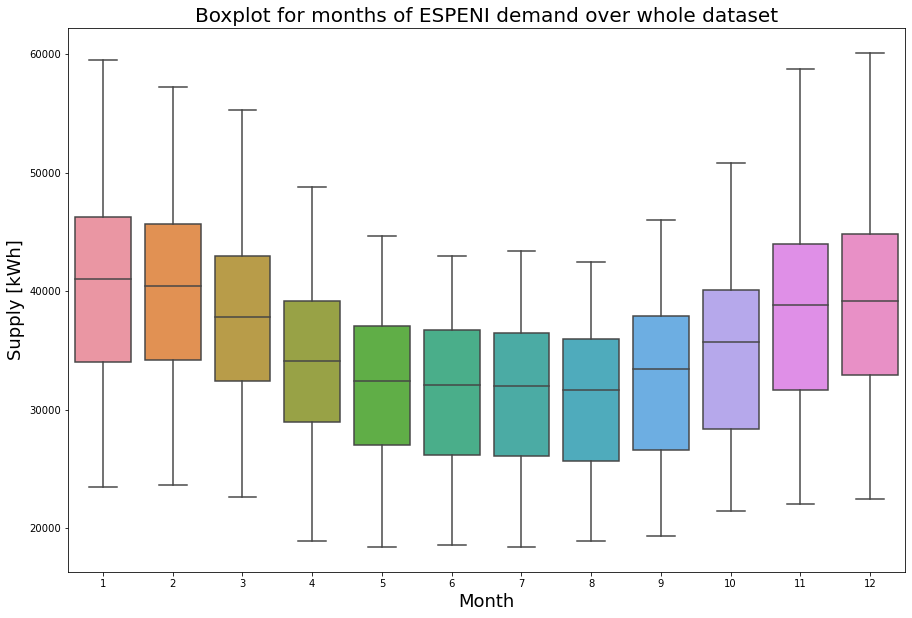

In [13]:
# Box plots over whole dataset for month values
fig, ax = plt.subplots()
fig.set_size_inches(15,10)
sns.boxplot(data=df_loads, x='Month', y='load')
ax.set_title('Boxplot for months of ESPENI demand over whole dataset', fontsize=20)
ax.set_xlabel('Month', fontsize=18)
ax.set_ylabel('Supply [kWh]', fontsize=18)

## Future data - FES2021

Future demand profiles are generated by scaling historical demand profiles to match the projected annual load from the FES2021 dataset. Different demand profiles from historical years can be chosen, and this along with the use of weather data forms the baseline year used to simulate future years. 

Distributions across buses are also obtained from FES2021 where data is available for distributions for the years 2020-2050 and all four scenarios.

In [14]:
start = '2050-01-01 00:00:00'
end = '2050-12-31 23:30:00'
# year of simulation
year = int(start[0:4])
# time step as fraction of hour
time_step = 0.5

year_baseline = 2019

loads.write_loads(year)
loads.write_loads_p_set(start, end, year, time_step, year_baseline=year_baseline)

df_loads = pd.read_csv('LOPF_data/loads-p_set.csv', index_col=0)
df_loads

,Beauly,Peterhead,Errochty,Denny/Bonnybridge,Neilston,Strathaven,Torness,Eccles,Harker,Stella West,...,Bramford,Pelham,Sundon/East Claydon,Melksham,Bramley,London,Kemsley,Sellindge,Lovedean,S.W.Penisula
name,,,,,,,,,,,,,,,,,,,,,
2050-01-01 00:00:00,172.177858,279.443120,96.973618,843.482849,998.380274,302.224453,263.158615,74.072727,259.205263,1539.730151,...,844.150141,534.803374,1748.608667,2284.251923,786.604429,5248.305280,881.182386,527.131574,1311.620440,1730.179046
2050-01-01 00:30:00,169.085781,274.424707,95.232105,828.335062,980.450744,296.796919,258.432650,72.742483,254.550295,1512.078725,...,828.990371,525.199044,1717.206071,2243.229914,772.478100,5154.052966,865.357567,517.665019,1288.065549,1699.107420
2050-01-01 01:00:00,170.001488,275.910890,95.747847,832.821020,985.760503,298.404262,259.832226,73.136429,255.928845,1520.267585,...,833.479877,528.043329,1726.505825,2255.378420,776.661557,5181.965416,870.044025,520.468502,1295.041236,1708.309159
2050-01-01 01:30:00,172.309569,279.656886,97.047800,844.128090,999.144007,302.455646,263.359924,74.129390,259.403548,1540.908001,...,844.795892,535.212484,1749.946303,2285.999311,787.206159,5252.320084,881.856465,527.534814,1312.623792,1731.502583
2050-01-01 02:00:00,170.164559,276.175553,95.839692,833.619889,986.706077,298.690501,260.081465,73.206584,256.174341,1521.725876,...,834.279378,528.549845,1728.161946,2257.541852,777.406556,5186.936126,870.878599,520.967752,1296.283482,1709.947825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-12-31 21:30:00,213.165119,345.965078,120.058369,1044.275521,1236.046568,374.169550,325.804016,91.705878,320.909561,1906.265797,...,1045.101663,662.114319,2164.868234,2828.022370,973.857087,6497.674178,1090.949503,652.616232,1623.854141,2142.051407
2050-12-31 22:00:00,206.065260,334.442070,116.059603,1009.493990,1194.877747,361.707140,314.952510,88.651444,310.221074,1842.774083,...,1010.292616,640.061375,2092.763287,2733.829846,941.420972,6281.257102,1054.613408,630.879639,1569.768671,2070.706416
2050-12-31 22:30:00,196.939558,319.631137,110.919845,964.788047,1141.961992,345.688759,301.004681,84.725471,296.482780,1761.165917,...,965.551306,611.715939,2000.084225,2612.760833,899.729677,6003.088510,1007.909330,602.940821,1500.250685,1979.004154


Text(0, 0.5, 'Load [MW]')

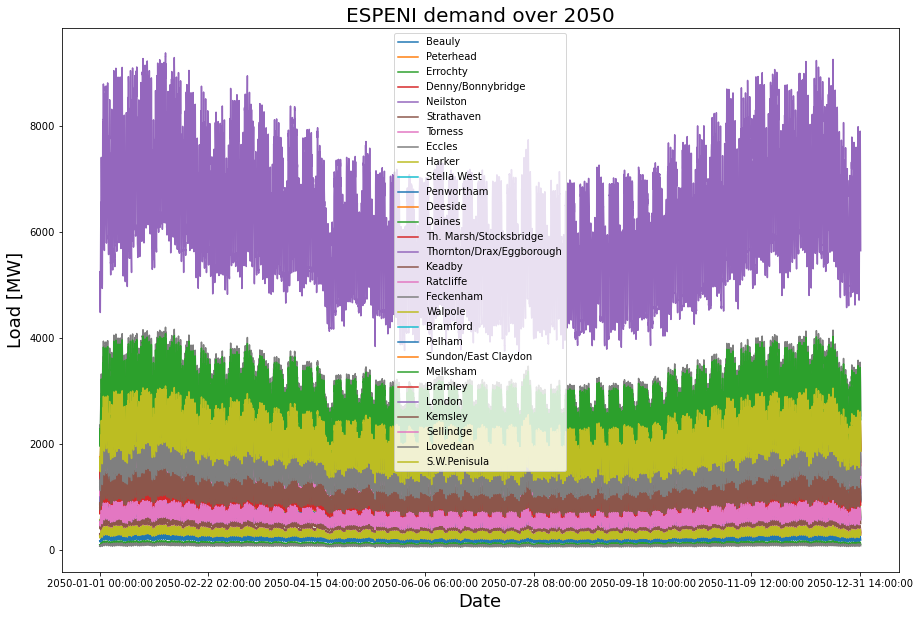

In [15]:
df_loads.plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 2050', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

In [16]:
df_loads['Total'] = df_loads.sum(axis=1)
df_loads['Total']

name
2050-01-01 00:00:00    32370.568182
2050-01-01 00:30:00    31789.237491
2050-01-01 01:00:00    31961.396276
2050-01-01 01:30:00    32395.330746
2050-01-01 02:00:00    31992.054689
                           ...     
2050-12-31 21:30:00    40076.442546
2050-12-31 22:00:00    38741.622381
2050-12-31 22:30:00    37025.930384
2050-12-31 23:00:00    35813.743873
2050-12-31 23:30:00    34850.362181
Name: Total, Length: 17520, dtype: float64

Text(0, 0.5, 'Load [MW]')

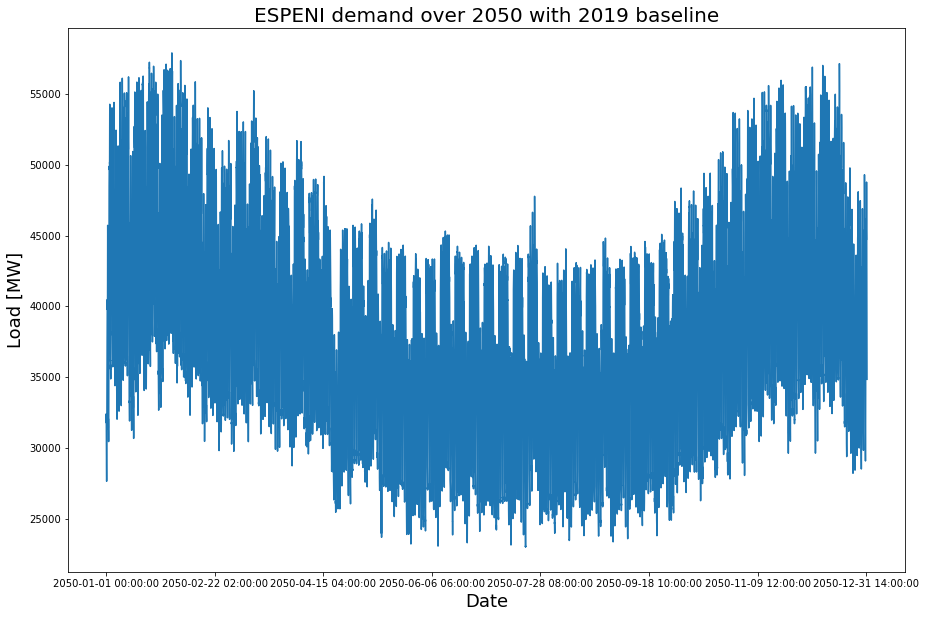

In [17]:
df_loads['Total'].plot(linestyle='-', figsize=(15,10))
plt.title('ESPENI demand over 2050 with 2019 baseline', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)

In [18]:
df_FES = pd.read_excel(
            '../data/FES2021/FES 2021 Data Workbook V04.xlsx',
            sheet_name='ED1', header=4, dtype=str)
df_FES_demand = df_FES.loc[df_FES['Data item'] == 'GBFES System Demand: Total']
scenario = 'Leading the Way'
df_FES_demand = df_FES_demand.loc[df_FES_demand['Scenario'] == scenario]
date = str(year) + '-01-01 00:00:00'
df_FES_demand.columns = df_FES_demand.columns.astype(str)
# future demand in GWh/yr
future_demand = df_FES_demand[date].values[0]
print(future_demand + ' GWh/year' + ' future total system demand in ' + str(year) + ' from FES2021 workbook')

686266 GWh/year future total system demand in 2050 from FES2021 workbook


In [19]:
print(str(round(df_loads['Total'].sum() / 2000, 0)) + ' GWh/year' + ' future total system demand in ' + str(year) + ' from checking dataframe by summing')

343133.0 GWh/year future total system demand in 2050 from checking dataframe by summing


In [20]:
df_loads

,Beauly,Peterhead,Errochty,Denny/Bonnybridge,Neilston,Strathaven,Torness,Eccles,Harker,Stella West,...,Pelham,Sundon/East Claydon,Melksham,Bramley,London,Kemsley,Sellindge,Lovedean,S.W.Penisula,Total
name,,,,,,,,,,,,,,,,,,,,,
2050-01-01 00:00:00,172.177858,279.443120,96.973618,843.482849,998.380274,302.224453,263.158615,74.072727,259.205263,1539.730151,...,534.803374,1748.608667,2284.251923,786.604429,5248.305280,881.182386,527.131574,1311.620440,1730.179046,32370.568182
2050-01-01 00:30:00,169.085781,274.424707,95.232105,828.335062,980.450744,296.796919,258.432650,72.742483,254.550295,1512.078725,...,525.199044,1717.206071,2243.229914,772.478100,5154.052966,865.357567,517.665019,1288.065549,1699.107420,31789.237491
2050-01-01 01:00:00,170.001488,275.910890,95.747847,832.821020,985.760503,298.404262,259.832226,73.136429,255.928845,1520.267585,...,528.043329,1726.505825,2255.378420,776.661557,5181.965416,870.044025,520.468502,1295.041236,1708.309159,31961.396276
2050-01-01 01:30:00,172.309569,279.656886,97.047800,844.128090,999.144007,302.455646,263.359924,74.129390,259.403548,1540.908001,...,535.212484,1749.946303,2285.999311,787.206159,5252.320084,881.856465,527.534814,1312.623792,1731.502583,32395.330746
2050-01-01 02:00:00,170.164559,276.175553,95.839692,833.619889,986.706077,298.690501,260.081465,73.206584,256.174341,1521.725876,...,528.549845,1728.161946,2257.541852,777.406556,5186.936126,870.878599,520.967752,1296.283482,1709.947825,31992.054689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2050-12-31 21:30:00,213.165119,345.965078,120.058369,1044.275521,1236.046568,374.169550,325.804016,91.705878,320.909561,1906.265797,...,662.114319,2164.868234,2828.022370,973.857087,6497.674178,1090.949503,652.616232,1623.854141,2142.051407,40076.442546
2050-12-31 22:00:00,206.065260,334.442070,116.059603,1009.493990,1194.877747,361.707140,314.952510,88.651444,310.221074,1842.774083,...,640.061375,2092.763287,2733.829846,941.420972,6281.257102,1054.613408,630.879639,1569.768671,2070.706416,38741.622381
2050-12-31 22:30:00,196.939558,319.631137,110.919845,964.788047,1141.961992,345.688759,301.004681,84.725471,296.482780,1761.165917,...,611.715939,2000.084225,2612.760833,899.729677,6003.088510,1007.909330,602.940821,1500.250685,1979.004154,37025.930384


## Peak loads

Scaling the load profile according to the annual energy demand to generate future load profiles results in overestimation of peak demands.

The analysis below shows the FES2021 data peak to be 94.7 GW, but the generated future load profile have a peak of 115.8 GW. Applying a moving average can reduce the peak demand to 99.2 GW. A smoothing algorithm is not currently applied.

In [21]:
# Leading the way, 2050 Electricity System ACS (Average Cold Spell) Peak Demand GW
peak_FES = 94.7

In [22]:
df_loads.max()

Beauly                        307.903082
Peterhead                     499.723941
Errochty                      173.416467
Denny/Bonnybridge            1508.387733
Neilston                     1785.388475
Strathaven                    540.463458
Torness                       470.602606
Eccles                        132.463147
Harker                        463.532886
Stella West                  2753.476344
Penwortham                   1541.080705
Deeside                      3094.666106
Daines                       3117.967297
Th. Marsh/Stocksbridge       2644.514010
Thornton/Drax/Eggborough     2257.261063
Keadby                        825.189098
Ratcliffe                    2125.919774
Feckenham                    4204.960198
Walpole                      1012.809620
Bramford                     1509.581041
Pelham                        956.380856
Sundon/East Claydon          3127.010661
Melksham                     4084.893465
Bramley                      1406.672907
London          

In [23]:
df_loads_smoothed = df_loads.rolling(48, min_periods=1).mean()
df_loads_smoothed.max()

Beauly                        264.013601
Peterhead                     428.491708
Errochty                      148.697134
Denny/Bonnybridge            1293.377368
Neilston                     1530.893547
Strathaven                    463.424085
Torness                       403.521420
Eccles                        113.581430
Harker                        397.459440
Stella West                  2360.987105
Penwortham                   1321.410180
Deeside                      2653.542597
Daines                       2673.522364
Th. Marsh/Stocksbridge       2267.556607
Thornton/Drax/Eggborough     1935.503922
Keadby                        707.564031
Ratcliffe                    1822.884436
Feckenham                    3605.571854
Walpole                       868.440529
Bramford                     1294.400578
Pelham                        820.055299
Sundon/East Claydon          2681.276658
Melksham                     3502.619813
Bramley                      1206.161296
London          

Text(0, 0.5, 'Load [MW]')

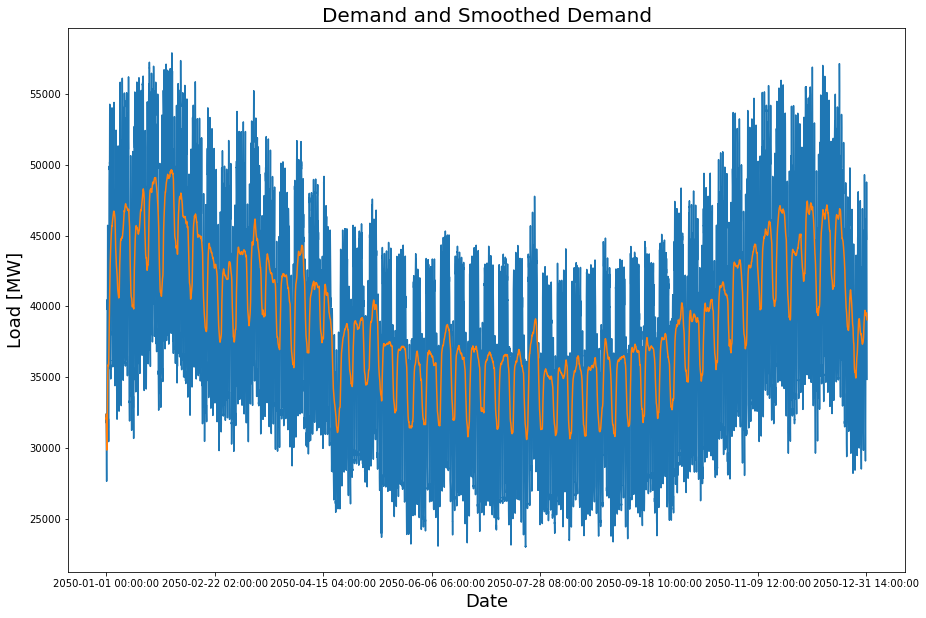

In [24]:
df_loads['Total'].plot(linestyle='-', figsize=(15,10))
df_loads_smoothed['Total'].plot(linestyle='-', figsize=(15,10))
plt.title('Demand and Smoothed Demand', fontsize=20)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Load [MW]', fontsize=18)